<a href="https://colab.research.google.com/github/abhi2596/ml-papers-implementation/blob/main/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Try to implement Neural Style Transfer paper.

# https://arxiv.org/pdf/1508.06576.pdf
# https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
# https://nextjournal.com/gkoehler/pytorch-neural-style-transfer
# https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb

In [ ]:
# from torchvision.models.feature_extraction import get_graph_node_names
# train_nodes, _ = get_graph_node_names(model)

In [ ]:
# def gram_matrix(F):
#   l = 1
#   l = torch.ones_like(F[0,:,:])
#   print(F[0,:,:])
#   for i in range(0,F.shape[0]):
#     l = torch.matmul(l,F[i,:,:])
#   # print(l)
#   return torch.sum(l)

In [ ]:
import torch
import torchvision
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
model = torchvision.models.vgg19(weights = "VGG19_Weights.DEFAULT").eval()
model = model.features

for i in model.parameters():
  i.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 150MB/s]


In [ ]:
content = Image.open("/content/pexels-lina-kivaka-1741206.jpg").convert("RGB")
target = Image.open("/content/starry-night-g9ef3a4639_1280.jpg").convert("RGB")

normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

# define transforms
transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
])

content = transform(content)
target = transform(target)
content = content.unsqueeze(0)
target = target.unsqueeze(0)

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

conv1_1 = create_feature_extractor(model,return_nodes=["0"])
conv2_1 = create_feature_extractor(model,return_nodes=["5"])
conv3_1 = create_feature_extractor(model,return_nodes=["10"])
conv4_1 = create_feature_extractor(model,return_nodes=["19"])
conv5_1 = create_feature_extractor(model,return_nodes=["28"])
conv4_2 = create_feature_extractor(model,return_nodes=["21"])

style_features = [conv1_1,conv2_1,conv3_1,conv4_1,conv5_1]
content_features = [conv4_2]

random_image = content.clone().detach()
random_image.requires_grad = True
content.requires_grad = False
target.requires_grad = False

def gram_matrix(input):
    a ,b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
from torch import nn
import torch

optimizer = torch.optim.Adam(lr = 0.01,params = [random_image])
layers = ["0","5","10","19","28"]

P = content_features[0](content)['21']
P = P.detach()

style_gram_matrix = []
for feature,layer_num in zip(style_features,layers):
  P_s = feature(target)[layer_num]
  P_s = P_s.detach()
  gram_matrix_p = gram_matrix(P_s)
  style_gram_matrix.append(gram_matrix_p)

for epoch in range(0,1000):
  content_loss = 0
  gram_matrix_f = 0
  gram_matrix_p = 0
  style_loss = 0
  total_loss = 0
  F = content_features[0](random_image)['21']
  content_loss +=  torch.mean((F - P) ** 2)
  for feature,layer_num,style_gram in zip(style_features,layers,style_gram_matrix):
    F = feature(random_image)[layer_num]
    N = F.shape[2]
    gram_matrix_f = gram_matrix(F)
    E = torch.mean((gram_matrix_f - style_gram)**2)
    style_loss += 1/5 * E
  total_loss = content_loss +  10**5 * style_loss
  optimizer.zero_grad()
  total_loss.backward(retain_graph=True)
  optimizer.step()
  if epoch%100 == 0:
    print("Epoch:",epoch)
    print("Total Loss:",total_loss.item())
    print("Content Loss:",content_loss.item())
    print("Style Loss:",style_loss.item())

Epoch: 0
Total Loss: 3467.96484375
Content Loss: 0.0
Style Loss: 0.03467964753508568
Epoch: 100
Total Loss: 234.3963623046875
Content Loss: 61.397789001464844
Style Loss: 0.0017299855826422572
Epoch: 200
Total Loss: 146.0711669921875
Content Loss: 53.81474304199219
Style Loss: 0.0009225642425008118
Epoch: 300
Total Loss: 118.21248626708984
Content Loss: 49.680572509765625
Style Loss: 0.0006853191298432648
Epoch: 400
Total Loss: 103.36186981201172
Content Loss: 46.98621368408203
Style Loss: 0.000563756562769413
Epoch: 500
Total Loss: 93.53398895263672
Content Loss: 45.06515884399414
Style Loss: 0.00048468829481862485
Epoch: 600
Total Loss: 86.36151123046875
Content Loss: 43.493492126464844
Style Loss: 0.00042868018499575555
Epoch: 700
Total Loss: 81.00518798828125
Content Loss: 42.28862380981445
Style Loss: 0.00038716563722118735
Epoch: 800
Total Loss: 76.88661193847656
Content Loss: 41.293277740478516
Style Loss: 0.0003559333854354918
Epoch: 900
Total Loss: 73.55844116210938
Content Lo

In [ ]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.1994, 0.2010, 0.2023)) + np.array(
    (0.4822, 0.4465, 0.4914))
  image = image.clip(0, 1)
  return image

output_image = im_convert(random_image)

In [ ]:
content_image = im_convert(content)
target_image = im_convert(target)

(-0.5, 223.5, 223.5, -0.5)

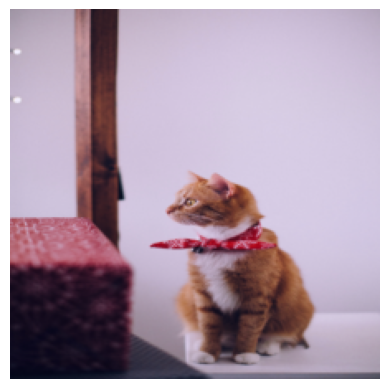

In [ ]:
plt.imshow(content_image)
plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

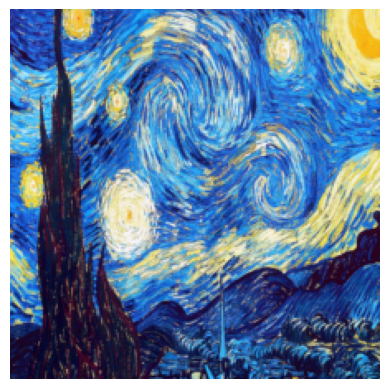

In [ ]:
plt.imshow(target_image)
plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

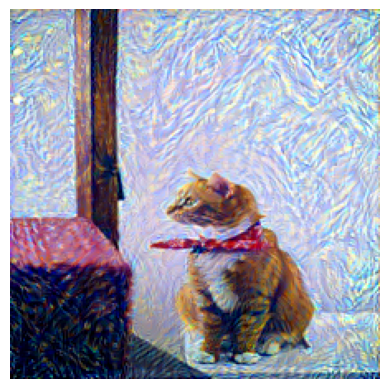

In [ ]:
plt.imshow(output_image)
plt.axis("off")